In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0d2a1c75635d01a00344cd5eb0fc5616a1ac9b6cb02820781f504f149b0d9967
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
pip install numpy==1.26.4

In [ ]:
# Imports
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from lime.lime_text import LimeTextExplainer
from sklearn.utils import resample

In [ ]:
# Load and Preprocess ISOT Dataset
column_names = ['title', 'text', 'subject', 'date']

import csv

column_names = ['title', 'text', 'subject', 'date']

true_df = pd.read_csv(
    "True.csv",
    names=column_names,
    header=None,
    on_bad_lines='skip',
    quoting=csv.QUOTE_MINIMAL,
    encoding='utf-8',
    skip_blank_lines=True,
    engine='python'  # Do not use low_memory with this
)

fake_df = pd.read_csv(
    "Fake.csv",
    names=column_names,
    header=None,
    on_bad_lines='skip',
    quoting=csv.QUOTE_MINIMAL,
    encoding='utf-8',
    skip_blank_lines=True,
    engine='python'
)

true_df['label'] = 1  # Real news
fake_df['label'] = 0  # Fake news

In [ ]:
# Combine and shuffle later
min_count = min(len(fake_df), len(true_df))

# Undersample fake news
df_fake_balanced = resample(fake_df, replace=False, n_samples=min_count, random_state=42)

# Undersample real news
df_real_balanced = resample(true_df, replace=False, n_samples=min_count, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_fake_balanced, df_real_balanced])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV (optional)
df_balanced.to_csv("balanced_isot.csv", index=False)

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch

# Load balanced data
df = pd.read_csv("balanced_isot.csv")
dataset = Dataset.from_pandas(df)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/16954 [00:00<?, ? examples/s]

In [ ]:
# Train/Test Split
train_test = dataset.train_test_split(test_size=0.3, seed=42)
train_dataset = train_test['train']
test_dataset = train_test['test']

In [ ]:
# Load model
from transformers import RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained("roberta-base")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# Trainer
training_args = TrainingArguments(
    output_dir="./results_roberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

In [ ]:
# Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chhabibegal (chhabibegal-amity-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.022500,0.004671,0.999214,1.000000,0.998436,0.999217
2,0.002000,0.001753,0.999803,1.000000,0.999609,0.999804
3,0.000000,0.001804,0.999803,1.000000,0.999609,0.999804


TrainOutput(global_step=2226, training_loss=0.005524322654974964, metrics={'train_runtime': 4228.4416, 'train_samples_per_second': 8.419, 'train_steps_per_second': 0.526, 'total_flos': 9367016681871360.0, 'train_loss': 0.005524322654974964, 'epoch': 3.0})

<Figure size 600x500 with 0 Axes>

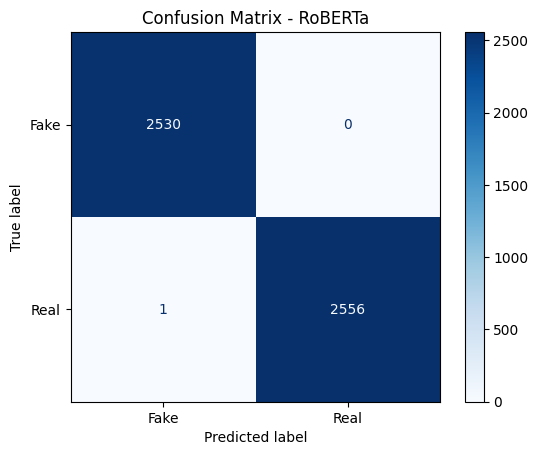

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - RoBERTa")
plt.show()

In [ ]:
import os
print(os.listdir("./results_roberta"))

['checkpoint-1484', 'runs', 'checkpoint-742', 'checkpoint-2226']


In [ ]:
# Save best model and tokenizer
trainer.save_model("roberta_model")
tokenizer.save_pretrained("roberta_model")

('roberta_model/tokenizer_config.json',
 'roberta_model/special_tokens_map.json',
 'roberta_model/vocab.json',
 'roberta_model/merges.txt',
 'roberta_model/added_tokens.json',
 'roberta_model/tokenizer.json')

In [ ]:
import shutil

# Zip the saved model directory
shutil.make_archive("roberta_model", 'zip', "roberta_model")

'/content/roberta_model.zip'

In [ ]:
from google.colab import files

# Download the zipped model to your local system
files.download("roberta_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# TO USE THE SAVED MODEL

In [ ]:
# Upload the zip
from google.colab import files
uploaded = files.upload()

Saving roberta_model.zip to roberta_model.zip


In [ ]:
# Unzip
import zipfile

with zipfile.ZipFile("roberta_model.zip", 'r') as zip_ref:
    zip_ref.extractall("roberta_model")

In [ ]:
# Load the model and tokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained("roberta_model")
model = RobertaForSequenceClassification.from_pretrained("roberta_model")

In [ ]:
from transformers import pipeline, RobertaForSequenceClassification, RobertaTokenizer

# Load saved model
model_path = "roberta_model"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

print("Manual Testing (type 'exit' to quit)\n")

while True:
    user_input = input("Enter news article text (NOTE:Enter full article, not just the headline): ")
    if user_input.lower() == "exit":
        break
    result = classifier(user_input)[0]
    label = result['label']
    score = result['score']

    readable = "REAL NEWS ✅" if label == "LABEL_1" else "FAKE NEWS ❌"
    print(f"\nPrediction: {readable}")
    print(f"Confidence: {score:.4f}\n")

Device set to use cpu


Manual Testing (type 'exit' to quit)

Enter news article text (NOTE:Enter full article, not just the headline): Immigration advocates have criticized Immigration and Customs Enforcement for detaining people suspected of being in the country illegally at workplaces, court hearings and traffic stops.   According to some social media users, ICE removal tactics also include flying immigrants on planes and dropping them in the ocean.   "People tracking the ICE deportation flights have found some of them are just flying to the middle of the ocean and turning around and coming right back. Also, bodies are washing up on the shores of Spain, cuffed and shackled," a woman says in a July 1 TikTok post. "You know, the way we saw them getting onto those planes? Also Sudan launched an investigation because a planeload of their people never arrived, and they're still unaccounted for. It's been about a month."

Prediction: REAL NEWS ✅
Confidence: 0.9999

Enter news article text (NOTE:Enter full articl

In [ ]:
# EXPLAINABILITY WITH LIME

In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Define class names
class_names = ['Fake', 'Real']

# Create the LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

# Wrapper function for LIME to use the HuggingFace pipeline
def predict_proba(texts):
    outputs = classifier(texts, return_all_scores=True)
    return np.array([[x['score'] for x in result] for result in outputs])

print("Manual Testing with LIME Explanation (type 'exit' to quit)\n")

while True:
    user_input = input("Enter news article text (NOTE: Enter full article, not just the headline): ")
    if user_input.lower() == "exit":
        break

    # Prediction
    result = classifier(user_input)[0]
    label = result['label']
    score = result['score']
    readable = "REAL NEWS ✅" if label == "LABEL_1" else "FAKE NEWS ❌"
    print(f"\nPrediction: {readable}")
    print(f"Confidence: {score:.4f}\n")

    # LIME explanation
    exp = explainer.explain_instance(user_input, predict_proba, num_features=10)

    # Show explanation in notebook or HTML
    try:
        from IPython.display import display
        display(exp.as_pyplot_figure())
        exp.show_in_notebook()
    except:
        print("\nTop influential words and their weights:")
        for word, weight in exp.as_list():
            print(f"{word}: {weight:.4f}")

Manual Testing with LIME Explanation (type 'exit' to quit)

Enter news article text (NOTE: Enter full article, not just the headline): Title: Eating Ice Cream Before Bed Increases Intelligence Text: A viral Japanese study claims that eating ice cream just before going to bed enhances brain performance and memory by up to 70%. Schools in Japan are now serving ice cream as part of exam preparation diets.

Prediction: REAL NEWS ✅
Confidence: 0.9018



/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


KeyboardInterrupt: 